# Case7-challenge00_pix2wcs


Modified version from Case7-0challengef by T. Kamizuka. 

In this note, we estimate the field parameters and distortion parameters from the observed positions on the focal plane in the overlapped plates. We also use reference stars (Gaia stars) whose sky coordinates are known in a certain accuracy. The SIP-convention distortion is considered in this note.

## Preparation

First, we load the data from https://github.com/xr0038/jasmine_warpfield/tree/master/challenge/case7.

In [2]:
import astropy.io.ascii as asc
import astropy.units as u

objects = asc.read('/Users/dkawata/work/obs/projs/JASMINE-Mission/analysis-testing-e2e/jasmine_warpfield/challenge/case7/case7_challenge_00.txt') #consists of x (um), y (um), catalog_id, ra (deg), dec (deg), and field.
pointings = asc.read('/Users/dkawata/work/obs/projs/JASMINE-Mission/analysis-testing-e2e/jasmine_warpfield/challenge/case7/case7_challenge_00_pointing.txt') # consists of field, ra (deg), dec (deg), and pa (deg).

We can convert the units of x and y from um to pix with assuming the pixel size to be 15 um. However, we will use um unit for the detector coordinates. The input data are created with Sip definition of crpix=[0,0] and origin=1, which map the origin to [0 um, 0 um].

In [3]:
pix_size = 15.*u.um
# objects['x'] = (objects['x']/pix_size).si
# objects['y'] = (objects['y']/pix_size).si
# objects: x (px), y (px), catalog_id, ra (deg), dec (deg), and field.
# pointings: field, ra (deg), dec (deg), and pa (deg).

Then, we change the ids for easy handling.

In [4]:
from astropy.table import unique
import numpy as np

ids = unique(objects, keys='catalog_id')['catalog_id']
objects.add_column(-1, name='id')
for i in range(0, np.size(ids)):
    pos = np.where(objects['catalog_id']==ids[i])
    objects['id'][pos] = i

objects.remove_column('catalog_id')
objects.rename_column('id', 'catalog_id')

Here, we make some arrays for further analysis. One new array is true_radec which stores true ra/dec values. Duplicated information (rows for the same object) is removed, and the rows are sorted with object ids. Another new array is observed_xy. It contains field ids, observed x/y positions on the focal plane, catalog ids. We rename ra, dec to ra_est, dec_est to store the estimated sky positions.

In [5]:
true_radec = objects['catalog_id', 'ra', 'dec'].copy()
true_radec.sort('catalog_id')
true_radec = unique(true_radec, keys='catalog_id') # consists of catalog_id, ra (deg), and dec (deg).

observed_xy = objects['field', 'x', 'y', 'catalog_id', 'ra', 'dec'].copy()
# observed_xy.rename_column('ra', 'ra_est')
# observed_xy.rename_column('dec', 'dec_est')
observed_xy.add_column(observed_xy['ra'], name='ra_est')
observed_xy.add_column(observed_xy['dec'],name='dec_est')
# observed_xy will have field, x (px), y (px), catalog_id, and estimated ra/dec (deg).

# initializing ra_est and dec_est
observed_xy['ra_est']  = 0.0
observed_xy['dec_est'] = 0.0

In addition, we make another array which stores field parameters, ra and dec (deg) of the origin of the pointing and position angle, pa (deg). The plate scale, um pixel scale to deg in the sky, is assumed to be the same value for all plates. At this time, an approximated (initial guess) value is stored in a variable (plate_scale).

In [6]:
field_params = pointings.copy() # field, ra (deg), dec (deg), and pa (deg).
true_field_params = field_params.copy()
# field_params['pa'] -= 240.0 # offset?
# plate_scale = 8.e-6*u.deg*(pix_size/u.um).si # in deg/pix
plate_scale = 8.e-6*u.deg/u.um
print(plate_scale)

8e-06 deg / um


Let's check the object distribution on sky.

Text(0, 0.5, 'dec (deg)')

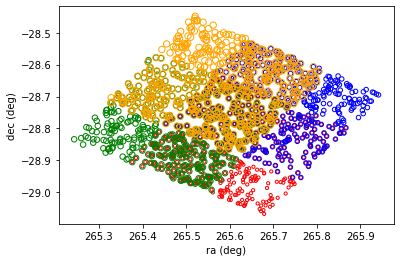

In [7]:
import matplotlib.pylab as plt
import numpy as np

color = ['red', 'blue', 'green', 'orange']

for i in range(0, np.max(field_params['field'])+1):
    pos = np.where(objects['field']==i)
    plt.scatter(objects['ra'][pos], objects['dec'][pos], marker='o', facecolor='None', edgecolor=color[i], s=10*i+10)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

We can see that the data consists of four image plates (different colours indicating the objects observd by the different plantes) and that the overlapped region has a size of about a 1/4 FoV.

We select the objects in the overlapped region for further analysis. Here, we select the regions all 4 plates overlaps, but we can use the region overlapped with at least 2 plates.

In [8]:
true_radec_overlap = true_radec.copy()
observed_xy_overlap = observed_xy.copy()
for cid in true_radec['catalog_id']:
    if np.count_nonzero(observed_xy['catalog_id']==cid)!=4:
    # if np.count_nonzero(observed_xy['catalog_id']==cid)<=1:
        pos = np.where(true_radec_overlap['catalog_id']==cid)[0]
        true_radec_overlap.remove_rows(pos)
        pos = np.where(observed_xy_overlap['catalog_id']==cid)[0]
        observed_xy_overlap.remove_rows(pos)
print(' The number of overlapped unique stars =', len(true_radec_overlap))
print(' The total number of observations of these overlapped stars =', len(observed_xy_overlap))

 The number of overlapped unique stars = 225
 The total number of observations of these overlapped stars = 900


Let's check the distribution of the selected unique objects.

225


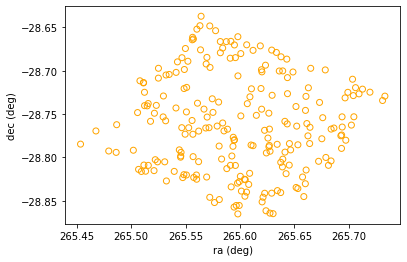

In [9]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='o', facecolor='None', edgecolor='orange')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
print(len(true_radec_overlap['ra']))

These objects will be used for the following analysis.

We again modify the catalog id for easy handling.

In [10]:
ids = unique(true_radec_overlap, keys='catalog_id')['catalog_id']
true_radec_overlap.add_column(-1, name='id')
observed_xy_overlap.add_column(-1, name='id')
for i in range(0, np.size(ids)):
    pos = np.where(true_radec_overlap['catalog_id']==ids[i])
    true_radec_overlap['id'][pos] = i
    pos = np.where(observed_xy_overlap['catalog_id']==ids[i])
    observed_xy_overlap['id'][pos] = i

true_radec_overlap.remove_column('catalog_id')
true_radec_overlap.rename_column('id', 'catalog_id')
observed_xy_overlap.remove_column('catalog_id')
observed_xy_overlap.rename_column('id', 'catalog_id')

## First guess of the positions

At first, we define a wcs constructor, including SIP polynomial distortion convention, https://irsa.ipac.caltech.edu/data/SPITZER/docs/files/spitzer/shupeADASS.pdf and https://docs.astropy.org/en/stable/api/astropy.wcs.Sip.html. 

In [11]:
from astropy.wcs import WCS
from astropy.wcs import Sip
import astropy.units as u

def wcs(ra_ptg, dec_ptg, pa_ptg, scale, a=None, b=None, ap=None, bp=None):
    w = WCS(naxis=2)
    w.wcs.crpix=[0,0]
    w.wcs.cdelt=np.array([-scale, scale])
    w.wcs.crval=[ra_ptg, dec_ptg]
    w.wcs.ctype=["RA---TAN-SIP", "DEC--TAN-SIP"]
    w.wcs.pc=[[ np.cos(pa_ptg*u.deg), -np.sin(pa_ptg*u.deg)],
              [np.sin(pa_ptg*u.deg), np.cos(pa_ptg*u.deg)]]
#    if a is not None and b is not None:
    w.sip = Sip(a, b, ap, bp, [0, 0])
    
    return w

Then, we estimate the sky coordinates from the observed focal-plane positions and (approximated) field parameters. Here, we do not add the distorption, but naively convert pixel coordinate (x, y) to sky coordinate, ($\alpha$, $\delta$) (ra_est, dec_est).

In [12]:
for i in range(0, np.size(field_params)):
    fp = field_params[i]
    w = wcs(fp['ra'], fp['dec'], fp['pa'], plate_scale.value)
    pos = np.where(observed_xy_overlap['field']==fp['field'])
    ret = w.all_pix2world(np.concatenate(([observed_xy_overlap[pos]['x']], [observed_xy_overlap[pos]['y']])).T, 0)
    observed_xy_overlap['ra_est'][pos]  = ret[:, 0]
    observed_xy_overlap['dec_est'][pos] = ret[:, 1]

Let's check the true positions and estimated positions.

 number of stars used = 900
 std of diff in ra = 6.642849111040708
 std of diff in dec = 5.976656840463815


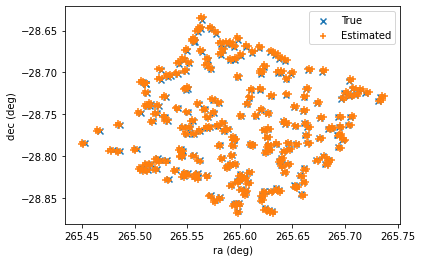

In [14]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(observed_xy_overlap['ra_est'], observed_xy_overlap['dec_est'], marker='+', label='Estimated')
print(' number of stars used =', len(observed_xy_overlap['ra_est']))
print(' std of diff in ra =', (np.std(observed_xy_overlap['ra_est'] \
                                      -observed_xy_overlap['ra'])*u.deg).to_value(u.arcsec))
print(' std of diff in dec =',(np.std(observed_xy_overlap['dec_est']
                                      -observed_xy_overlap['dec'])*u.deg).to_value(u.arcsec))
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.legend()

Test for distortion with A/B, using the following c and d.

In [13]:
c = np.zeros(shape=(3, 3))
d = np.zeros(shape=(3, 3))

c[0,2]=-2.34153374723336e-09
c[1,1]=1.5792128155073916e-08
c[1,2]=7.674347291529089e-15
c[2,0]=-4.694743859349522e-09
c[2,1]=5.4256004358596465e-15
c[2,2]=-4.6341769281246224e-21
d[0,2]=-1.913280244657798e-08
d[1,1]=-5.622875292409728e-09
d[1,2]=-1.0128311203344238e-14
d[2,0]=3.1424733259527392e-09
d[2,1]=-9.08024075521211e-15
d[2,2]=-1.4123037013352912e-20

We check if all_pix2world takes into account SIP parameters of A and B by comparing ($\alpha$, $\delta$) converted from (x, y) pixel coordinate without distortion (above observed_xy_overlap['ra_est'] and observed_xy_overlap['dec_est']) and ($\alpha$, $\delta$) converted from (x, y) pixel coordinate with A and B, ra_dist, dec_dist below.

 diff ra=          ra_est        
          deg          
-----------------------
 1.8201350997060217e-05
   9.60581496656232e-06
 -7.802975517279265e-06
 -1.946410702657886e-05
-1.6551439671275148e-05
-1.3200699129356508e-05
  1.209157744597178e-06
-2.9153682135074632e-08
  1.622400435508098e-05
-1.4921175761628547e-06
                    ...
  -6.71867593382558e-06
-1.2957685498804494e-05
  2.920086785707099e-07
 2.3814620249140717e-06
  5.746174736032117e-06
  4.458012375607723e-05
 2.1436671090668824e-05
  3.407003384836571e-05
 4.9868886947024293e-05
  0.0001081956477833046
Length = 900 rows
 diff dec=         dec_est        
          deg          
-----------------------
 2.4965962222012195e-05
 1.3426362144741688e-05
-1.1419687783842392e-05
-2.8966534536323252e-05
 -2.477087401331346e-05
-1.9717471126057262e-05
 4.2073839523482093e-07
 -4.644613227355876e-08
  2.246222383561758e-05
-2.1995200860658315e-06
                    ...
  -9.18505586611218e-06
-1.8002651565041106e-05
 

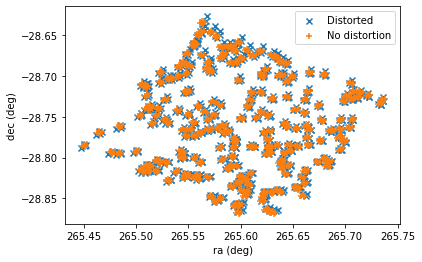

In [14]:
# print(observed_xy_overlap['ra_est'])
c *= 100.0
ra_dist = np.zeros_like(observed_xy_overlap['ra_est'])
dec_dist = np.zeros_like(observed_xy_overlap['dec_est'])

for i in range(0, np.size(field_params)):
    fp = field_params[i]
    w = wcs(fp['ra'], fp['dec'], fp['pa'], plate_scale.value, a=c, b=d)
    pos = np.where(observed_xy_overlap['field']==fp['field'])
    ret = w.all_pix2world(np.concatenate(([observed_xy_overlap[pos]['x']], [observed_xy_overlap[pos]['y']])).T, 0)
    ra_dist[pos] = ret[:,0]
    dec_dist[pos] = ret[:,1]
    
print(' diff ra=', ra_dist-observed_xy_overlap['ra_est'])
print(' diff dec=', dec_dist-observed_xy_overlap['dec_est'])

plt.scatter(ra_dist, dec_dist, marker='x', label='Distorted')
plt.scatter(observed_xy_overlap['ra_est'], observed_xy_overlap['dec_est'], marker='+', label='No distortion')
print(' number of stars used =', len(observed_xy_overlap['ra_est']))
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.legend()
    

Check if these stars cover the large enough detector region by looking at their (x, y) position in the detector coordinate. 

 number of all stars= 2574


Text(0, 0.5, 'y (pix)')

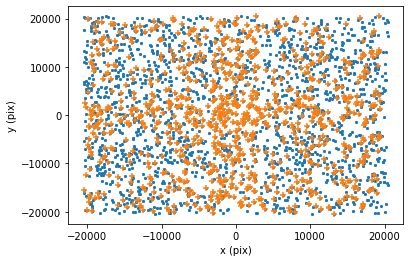

In [15]:
plt.scatter(objects['x'], objects['y'], marker='x', label='All', s=5)
print(' number of all stars=', len(objects['x']))
plt.scatter(observed_xy_overlap['x'], observed_xy_overlap['y'], marker='+', label='Overlap')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')


Here, there are four estimated (ignoring distortion) positions, (observed_xy_overlap['ra_est'], observed_xy_overlap['dec_est']), in the sky coordinate for each unique object. We take their mean values as the first-guess positions and store them in radec_est array.

In [16]:
from astropy.table import Table

radec_est = Table(names=['catalog_id', 'ra_est', 'dec_est'], \
            dtype=['int64', 'float64', 'float64'])
#           units=[None, u.deg, u.deg], \
#           dtype=['int64', 'float64', 'float64'])

radec_est['ra_est'].unit = u.deg
radec_est['dec_est'].unit = u.deg

cat_ids = unique(observed_xy_overlap, 'catalog_id')['catalog_id']

for i in cat_ids:
    pos = np.where(observed_xy_overlap['catalog_id'] == i)
    ra = np.mean(observed_xy_overlap[pos]['ra_est'])*u.deg
    dec = np.mean(observed_xy_overlap[pos]['dec_est'])*u.deg
    radec_est.add_row([i, ra, dec])
    
# print('radec_est=', radec_est)


Let's check the estimated positions.

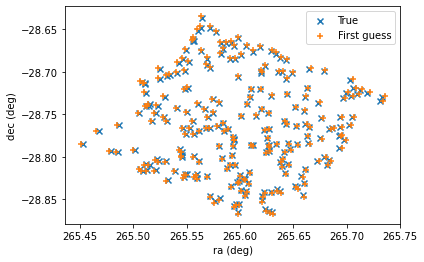

In [17]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(radec_est['ra_est'], radec_est['dec_est'], marker='+', label='First guess')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.legend()

## Parameter adjustment

At first, we define a function which calculates x/y positions from the ra/dec values estimated above and the field/catalog ids.

In [18]:
def xy_calculator(observed_xy, field_params, plate_scale, ap, bp, radec_info):
    # observed_xy:  consists of field, x (px), y (px), catalog_id, ra_est (deg), and dec_est(deg).
    # field_params: consists of field, ra (deg), dec (deg), and pa (deg).
    # radec_info:   consists of catalog_id, ra_est (deg), and dec_est (deg).

    observed_xy_cp = observed_xy.copy()
    observed_xy_cp.rename_column('x', 'x_est')
    observed_xy_cp.rename_column('y', 'y_est')
    observed_xy_cp['x_est']   = None
    observed_xy_cp['y_est']   = None
    observed_xy_cp['ra_est']  = None
    observed_xy_cp['dec_est'] = None

    for i in range(0, np.size(radec_info)):
        pos = np.where(observed_xy_cp['catalog_id']==radec_info[i]['catalog_id'])
        observed_xy_cp['ra_est'][pos]  = radec_info[i]['ra_est']
        observed_xy_cp['dec_est'][pos] = radec_info[i]['dec_est']
    
    for i in range(0, np.size(field_params)):
        fp = field_params[i]
        w = wcs(fp['ra'], fp['dec'], fp['pa'], plate_scale, ap=ap, bp=bp)
        pos = np.where(observed_xy_cp['field']==fp['field'])
        radec0 = np.concatenate(([observed_xy_cp[pos]['ra_est']], [observed_xy_cp[pos]['dec_est']])).T
        ret = w.sip_foc2pix(w.wcs_world2pix(radec0, 1)-w.wcs.crpix, 1)
        observed_xy_cp['x_est'][pos] = ret[:, 0]
        observed_xy_cp['y_est'][pos] = ret[:, 1]

    return observed_xy_cp['x_est', 'y_est']

Next, we define a function to map from (x, y) pixel coordinate to ($\alpha$, $\delta$), using A/B Sip distortion parameters using wcs.all_pix2world, https://docs.astropy.org/en/stable/api/astropy.wcs.WCS.html#astropy.wcs.WCS.all_pix2world with input field parameters of $\alpha_{\rm ptgs}$ (deg), $\delta_{\rm ptgs}$ (deg) and pa$_{\rm ptgs}$ (deg) of each field (plate) pointing. This conversion is described as follows. Here, we follow the description at https://www.stsci.edu/itt/review/DrizzlePac/HTML/ch33.html

#### Definition

CRVAL1: $\alpha_{\rm ptgs}$ right assension at the pointing centre.

CRVAL2: $\delta_{\rm ptgs}$ declination at the pointing centre.

CRPIX1: the x reference location of the image plate, corresponding to the pointing centre. We set CRPIX1=0.

CRPIX2: the y reference location of the image plate, corresponding to the pointing centre. We set CRPIX2=0.

CDELT1: x-scale. We set -scale.

CDELT2: y-scale. We set scale.


wcs compute the sky coordidate, ($\alpha$, $\delta$) of star at (x, y) on the detector as follows (This needs to be confirmed...).

According to https://irsa.ipac.caltech.edu/data/SPITZER/docs/files/spitzer/shupeADASS.pdf , intermediate world coordinate, $(\alpha', \delta')$ are computed with

$$
\begin{pmatrix}
\alpha' \\
\delta' \\
\end{pmatrix}
=
\begin{pmatrix}
CD_{11} & CD_{12} \\
CD_{21} & CD_{22} \\
\end{pmatrix}
\begin{pmatrix}
x+f(x,y) \\
y+g(x,y) \\
\end{pmatrix},
$$

where 

$$
f(x,y) = \sum_{p,q} A_{pq} x^p, y^q \ \ \ \  p+q\leq {\rm A_{ORDER}}, \\
g(x,y) = \sum_{p,q} B_{pq} x^p, y^q \ \ \ \  p+q\leq {\rm B_{ORDER}}. \\
$$

${A_{ORDER}}$ and ${B_{ORDER}}$ is the order of polynomial. For example, with ${A_{ORDER}}=3$, $f(x,y)$ can be described as,

$
f(x,y) = A_{20} x^2 + A_{02} y^2 + A_{11} x y + A_{21} x^2 y + A_{12} x y^2 + A_{30} x^3 + A_{03} y^3.
$

Note that $p,q\leq1$ components, i.e. $A_{00}=A_{01}=A_{10}$, are ignored here. **Therefore, we set $A_{00}=A_{01}=A_{10}$.** From the intermediate world coordinate $(\alpha', \delta')$ to the world coordinate $(\alpha, \delta)$ is taken care by WCS ([Greisen & Calabretta 2002, A&A, 395, 1061](https://ui.adsabs.harvard.edu/abs/2002A%26A...395.1061G/abstract); [Clabretta & Greisen 2002, A&A, 395, 1077](https://ui.adsabs.harvard.edu/abs/2002A%26A...395.1077C/abstract)). CD matrix above is considered to be described (**need to check** ).

$$
\begin{pmatrix}
CD_{11} & CD_{12} \\
CD_{21} & CD_{22} \\
\end{pmatrix}
=
\begin{pmatrix}
{\rm CDELT1} \cos({\rm pa_{ptgs}}) & -{\rm CDELT2} \sin({\rm pa_{ptgs}}) \\
{\rm CDELT1} \sin({\rm pa_{ptgs}}) & {\rm CDELT2} \cos({\rm pa_{ptgs}}),  \\
\end{pmatrix}
$$

according to equation (189) in [Clabretta & Greisen 2002, A&A, 395, 1077](https://ui.adsabs.harvard.edu/abs/2002A%26A...395.1077C/abstract).

#### Note that here, we do not have a term to describe a linear skewness.

In [19]:
def radec_calculator_ab(observed_xy, field_params, plate_scale, a, b):
    # observed_xy:  consists of field, x (px), y (px), catalog_id, ra_est (deg), and dec_est(deg).
    # field_params: consists of field, ra (deg), dec (deg), and pa (deg).

    
    observed_xy_cp = observed_xy.copy()
    # observed_xy_cp.rename_column('x', 'x_est')
    # observed_xy_cp.rename_column('y', 'y_est')
    # observed_xy_cp['x_est']   = None
    # observed_xy_cp['y_est']   = None
    observed_xy_cp['ra_est']  = None
    observed_xy_cp['dec_est'] = None
    
    for i in range(0, np.size(field_params)):
        fp = field_params[i]
        w = wcs(fp['ra'], fp['dec'], fp['pa'], plate_scale, a=a, b=b)
        pos = np.where(observed_xy_cp['field']==fp['field'])
        pix0 = np.concatenate(([observed_xy_cp[pos]['x']], [observed_xy_cp[pos]['y']])).T
        ret = w.all_pix2world(pix0, 1)
        # ret = w.sip_pix2foc(w.wcs_pix2world(pix0, 1)-w.wcs.crval, 1)
        observed_xy_cp['ra_est'][pos]  = ret[:, 0]
        observed_xy_cp['dec_est'][pos] = ret[:, 1]
    
    return observed_xy_cp['ra_est', 'dec_est']

### Using scipy.optimize least_squares, assuming the pointing sky coordinate, RA, DEC are accurately known.

Define model function to solve with Least Squares. Here, we consider that the position of the pointings, $(\alpha_{\rm ptgs}, \delta_{\rm ptgs})$ are accurately known, and they are fixed. Following equation (1) of [Bernstein et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017PASP..129g4503B/abstract), we minimise the following $\chi^2$ to fit the parameters of position angle of ${\rm pa_{ptgs,p}}$ for each image plate, p, and the common "scale" parameter to convert pixel unit of um to world coordinate unit of deg, in addition to the components of ${\rm A_p}$, ${\rm B_p}$ distortion matrices. 

$
\chi^2 = \sum_i (w_i | \alpha_{i,s} - \bar{\alpha_s}|)^2,
$

where $\alpha_{i,s}({\rm pa_{ptgs,p}, {\rm scale}, A_p, B_p})$ is the world coordinate position estimated from $(x_i, y_i)$ for star s on a plate p, using the parameters for plate p, ${\rm pa_{ptgs,p}, A_p, B_p}$. $\bar{\alpha_s}$ is the mean sky position of star s, and described as

$$
 \bar{\alpha_s} = \frac{\sum_{i\in s} w_i \alpha_{i,s}}{\sum_{i\in s} w_i}.
$$

Here, we do not take into account any error, and set $w_i = 1$. 


In [20]:
import copy

# def model_func(params, n_fields, dim_sip, observed_xy):
def model_func(params, ra_ptgs, dec_ptgs, n_fields, dim_sip, observed_xy):
    # params = (ra_ptgs, dec_ptgs, pa_ptg..., scale, a..., b...)
    pa_ptgs, scale, a, b =\
          np.split(params, [n_fields, n_fields+1,\
                          n_fields+1+(dim_sip+1)**2])
    # ra_ptgs, dec_ptgs, pa_ptgs, scale, a, b =\
    #    np.split(params, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
    #                      3*n_fields+1+(dim_sip+1)**2])

    field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
#                         names=['ra', 'dec', 'pa', 'field'],\
#                         units=[u.deg, u.deg, u.deg, None],\
#                         dtype=['float64', 'float64', 'float64', 'int64'])
    field_params['ra'].unit = u.deg
    field_params['dec'].unit = u.deg
    field_params['pa'].unit = u.deg
    field_params['field'] = np.arange(0, np.size(field_params))
    
    # use copy of observed_xy
    observed_xy_cp = observed_xy.copy()
    
    a_matrix = np.reshape(a, (dim_sip+1, dim_sip+1))
    b_matrix = np.reshape(b, (dim_sip+1, dim_sip+1))
    
    # mns = np.concatenate(((0, 1), np.arange(dim_sip+1, 2*(dim_sip)+1))) 
    # for mn in mns:
    #    for m in range(np.max([0, mn-dim_sip]), np.min([mn+1, dim_sip+1])):
    #        n = mn - m
    #        ap_matrix[m, n] = 0
    #        bp_matrix[m, n] = 0
    # a_matrix[0, 0] = 0.0
    # a_matrix[0, 1] = 0.0
    # a_matrix[1, 0] = 0.0
    # b_matrix[0, 0] = 0.0
    # b_matrix[0, 1] = 0.0
    # b_matrix[1, 0] = 0.0

    m, n = np.indices((dim_sip+1, dim_sip+1))
    mn = m + n
    a_matrix = a_matrix * (1.e-3**mn)
    b_matrix = b_matrix * (1.e-3**mn)
    
    # compute ra/dec from x/y with the parameters.
    ret = radec_calculator_ab(observed_xy_cp, field_params, scale[0], \
                                                              a_matrix, b_matrix)
    
    observed_xy_cp['ra_est'] = ret['ra_est']
    observed_xy_cp['dec_est'] = ret['dec_est']
    
    # compute the mean ra/dec for unique stars
    cat_ids = unique(observed_xy_cp, 'catalog_id')['catalog_id']
    
    ra_mean = np.zeros(len(observed_xy['ra_est']))
    dec_mean = np.zeros(len(observed_xy['dec_est']))
    
    # effective RA
    observed_xy_cp['ra_est'] = observed_xy_cp['ra_est']*np.cos(observed_xy_cp['dec_est'].data*u.deg)

    for i in cat_ids:
        pos = np.where(observed_xy_cp['catalog_id'] == i)
        ra_mean[pos] = np.mean(observed_xy_cp[pos]['ra_est'])*u.deg
        dec_mean[pos] = np.mean(observed_xy_cp[pos]['dec_est'])*u.deg
    

    radec_est = np.concatenate((observed_xy_cp['ra_est'], observed_xy_cp['dec_est']))
    radec_est_mean = np.concatenate((ra_mean, dec_mean))
    

    residuals = radec_est - radec_est_mean

    return residuals

Next, we execute the least-square calculation to derive the field parameters and sky positions of the objects in the overlapped region.

In [21]:
from scipy.optimize import least_squares
import time

dim_sip = 3
a = np.zeros(shape=(dim_sip+1, dim_sip+1))
b = np.zeros(shape=(dim_sip+1, dim_sip+1))

# constructing a_init (initial parameter set).
# a_init = np.array(np.concatenate((field_params['ra'], field_params['dec'], field_params['pa'], \
#                                   [plate_scale.value], a.flatten(), b.flatten()))) # This must be an ndarray.
a_init = np.array(np.concatenate((field_params['pa'], \
                                  [plate_scale.value], a.flatten(), b.flatten()))) # This must be an ndarray.
print(' # of fitting parameters =', len(a_init))
# constraining ra/dec values in 'observed' between -180 and 180 deg.
# measured = np.concatenate((observed_xy_overlap['x'], observed_xy_overlap['y']))
# print(' # of data points =', len(measured))
#pos = np.where(measured>180.)
#measured[pos] -= 360.
#pos = np.where(measured<-180.)
#measured[pos] += 360.

start = time.time()
# result = least_squares(model_func, a_init, loss='linear', args=(np.size(field_params), \
#                         dim_sip, observed_xy_overlap), \
#                       verbose=2)
result = least_squares(model_func, a_init, loss='linear', args=(field_params['ra'], \
                      field_params['dec'], np.size(field_params), dim_sip, observed_xy_overlap), \
                      verbose=2)
print(' time=',time.time()-start)

## pa should be a positive value between 0 and 360.
#if result[3] < 0:
#    result[3] = -result[3]
#    result[2] = result[2] + 180.0
#
#if result[2] > 360.0 or result[2] < 0.0:
#    result[2] = result[2]%360.0

 # of fitting parameters = 37
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.0543e-03                                    6.68e+04    
       1              2         1.7355e-10      5.05e-03       6.04e+02       2.12e-03    
       2              3         3.1920e-16      1.74e-10       1.21e+03       1.50e-04    
       3              4         3.1478e-16      4.42e-18       2.42e+03       1.28e-05    
       4              5         3.1453e-16      2.57e-19       4.83e+03       4.41e-06    
       5              6         3.1450e-16      2.80e-20       4.83e+03       3.92e-05    
       6              7         3.1440e-16      9.48e-20       1.21e+03       4.72e-05    
       7              8         3.1422e-16      1.83e-19       3.02e+02       1.37e-05    
       8             21         3.1422e-16      0.00e+00       0.00e+00       1.37e-05    
`xtol` termination condition is satisfied.
Function evaluati

### Checking results

#### Preparation

Extracting the resaltnat fitting parameter values. 

In [22]:
n_fields = np.size(field_params)
n_objects = np.size(radec_est)
true_ra_ptgs = true_field_params['ra'].data
true_dec_ptgs = true_field_params['dec'].data
true_pa_ptgs = true_field_params['pa'].data

# ra_ptgs, dec_ptgs, pa_ptgs, scale, a, b =\
#       np.split(result.x, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
#                           3*n_fields+1+(dim_sip+1)**2])
pa_ptgs, scale, a, b =\
       np.split(result.x, [n_fields, n_fields+1,\
                           n_fields+1+(dim_sip+1)**2])
ra_ptgs = field_params['ra'].data
dec_ptgs = field_params['dec'].data

a_matrix = np.reshape(a, (dim_sip+1, dim_sip+1))
b_matrix = np.reshape(b, (dim_sip+1, dim_sip+1))
# A/B scaling
m, n = np.indices((dim_sip+1, dim_sip+1))
mn = m + n
a_matrix = a_matrix * (1.e-3**mn)
b_matrix = b_matrix * (1.e-3**mn)

fit_field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
fit_field_params['ra'].unit = u.deg
fit_field_params['dec'].unit = u.deg
fit_field_params['pa'].unit = u.deg
fit_field_params['field'] = np.arange(0, np.size(field_params))

#### Pointings

The central position of the pointings are not fitted, but fixed with the true values. Hence, the differences should be zero. 

In [23]:
print(' pointing centre (fit) ra, dec (deg) =', ra_ptgs, dec_ptgs)
print(' pointing centre (true) ra, dec (deg) =', true_ra_ptgs, true_dec_ptgs)
print(' difference ra, dec (deg) =', ra_ptgs-true_ra_ptgs, dec_ptgs-true_dec_ptgs)

 pointing centre (fit) ra, dec (deg) = [265.62153148 265.6996346  265.48921727 265.57142097] [-28.85151127 -28.74179839 -28.78387164 -28.67029473]
 pointing centre (true) ra, dec (deg) = [265.62153148 265.6996346  265.48921727 265.57142097] [-28.85151127 -28.74179839 -28.78387164 -28.67029473]
 difference ra, dec (deg) = [0. 0. 0. 0.] [0. 0. 0. 0.]


#### Pointings position angles without  A00=A01=A10=0

In [24]:
print(' position angle (fit) (deg) =', pa_ptgs)
print(' position angle (true) (deg) =', true_pa_ptgs)
print(' difference =', pa_ptgs-true_pa_ptgs)

 position angle (fit) (deg) = [301.84892078 301.85327395 301.24457824 303.6561951 ]
 position angle (true) (deg) = [301.8490035  301.85335708 301.24465943 303.65627669]
 difference = [-8.27252290e-05 -8.31257240e-05 -8.11842332e-05 -8.15856362e-05]


#### Pointings position angles with A00=A01=A10=0

In [25]:
print(' position angle (fit) (deg) =', pa_ptgs)
print(' position angle (true) (deg) =', true_pa_ptgs)
print(' difference =', pa_ptgs-true_pa_ptgs)

 position angle (fit) (deg) = [301.84892078 301.85327395 301.24457824 303.6561951 ]
 position angle (true) (deg) = [301.8490035  301.85335708 301.24465943 303.65627669]
 difference = [-8.27252290e-05 -8.31257240e-05 -8.11842332e-05 -8.15856362e-05]


#### Scale (deg/um) without A00=A01=A10=0

In [26]:
print(' scale (fit) deg/um=', scale)
print(' true scale =',(1e-6/7.3/np.pi*180.0)*u.deg/u.um)
# print(' true scale =',(1e-6/7.3/np.pi*180.0)*u.deg*(pix_size/u.um).si)
print(' difference =', scale-(1e-6/7.3/np.pi*180.0))

 scale (fit) deg/um= [7.84874899e-06]
 true scale = 7.848736919600318e-06 deg / um
 difference = [1.20682027e-11]


#### Scale (deg/pix) with  A00=A01=A10=0

In [27]:
print(' scale (fit) deg/um=', scale)
print(' true scale =',(1e-6/7.3/np.pi*180.0)*u.deg/u.um)
# print(' true scale =',(1e-6/7.3/np.pi*180.0)*u.deg*(pix_size/u.um).si)
print(' difference =', scale-(1e-6/7.3/np.pi*180.0))

 scale (fit) deg/um= [7.84874899e-06]
 true scale = 7.848736919600318e-06 deg / um
 difference = [1.20682027e-11]


#### A/B

In [28]:
print(' derived A/B matrices = ', a_matrix, b_matrix)

 derived A/B matrices =  [[-2.13926412e-03 -1.43205638e-06  2.34120736e-09  5.15340409e-17]
 [-1.53974354e-06 -1.57923180e-08 -7.69036358e-15 -5.89302595e-10]
 [ 4.69528157e-09 -5.75127914e-15  2.87258684e-09  2.10478601e-12]
 [ 9.05485000e-17 -1.88203419e-09  2.49992417e-12  1.17720375e-15]] [[-3.20865288e-03 -1.53804231e-06  1.91343968e-08  7.41044219e-16]
 [ 1.44213978e-06  5.62393030e-09  1.03126657e-14  2.21030588e-09]
 [-3.14052537e-09  9.11684852e-15  3.57544687e-10 -2.28536606e-12]
 [-5.73901054e-17 -2.95460355e-09 -1.55776306e-12 -2.01656637e-15]]


with A00=A01=A10=0 fix.

In [29]:
print(' derived A/B matrices = ', a_matrix, b_matrix)

 derived A/B matrices =  [[-2.13926412e-03 -1.43205638e-06  2.34120736e-09  5.15340409e-17]
 [-1.53974354e-06 -1.57923180e-08 -7.69036358e-15 -5.89302595e-10]
 [ 4.69528157e-09 -5.75127914e-15  2.87258684e-09  2.10478601e-12]
 [ 9.05485000e-17 -1.88203419e-09  2.49992417e-12  1.17720375e-15]] [[-3.20865288e-03 -1.53804231e-06  1.91343968e-08  7.41044219e-16]
 [ 1.44213978e-06  5.62393030e-09  1.03126657e-14  2.21030588e-09]
 [-3.14052537e-09  9.11684852e-15  3.57544687e-10 -2.28536606e-12]
 [-5.73901054e-17 -2.95460355e-09 -1.55776306e-12 -2.01656637e-15]]


#### Object positions

 field params=         ra                 dec                 pa         field
       deg                 deg                deg              
------------------ ------------------- ------------------ -----
265.62153148319356 -28.851511272277236  301.8489207758511     0
 265.6996346022487  -28.74179839183368 301.85327395140433     1
 265.4892172664734 -28.783871644305666  301.2445782414299     2
265.57142097465146  -28.67029473412515 303.65619509941047     3


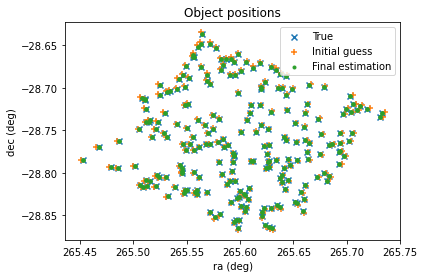

In [30]:
print(' field params=', fit_field_params)
radec_objs = radec_calculator_ab(observed_xy_overlap, fit_field_params, scale[0], a_matrix, b_matrix)

plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(radec_est['ra_est'], radec_est['dec_est'], marker='+', label='Initial guess')
plt.scatter(radec_objs['ra_est'], radec_objs['dec_est'], marker='.', label='Final estimation')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Object positions')
plt.legend()

#### Position difference

In [31]:
from astropy.coordinates import SkyCoord

distlist = []
print(np.shape(radec_objs))
for i in range(0, np.size(radec_objs)):
    c1 = SkyCoord(radec_objs['ra_est'][i]*u.deg, radec_objs['dec_est'][i]*u.deg)
    c2 = SkyCoord(observed_xy_overlap['ra'][i]*u.deg, observed_xy_overlap['dec'][i]*u.deg)
    distlist.append(c1.separation(c2).arcsec)
distlist = np.array(distlist)

(900,)


Text(0, 0.5, 'Number')

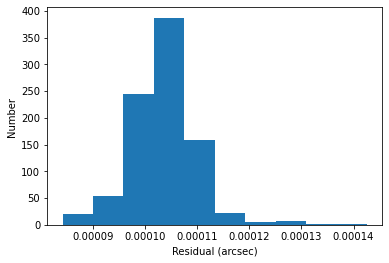

In [32]:
#plt.hist(np.log10(distlist))
plt.hist(distlist)
plt.xlabel("Residual (arcsec)")
plt.ylabel("Number")

Text(0, 0.5, 'dDEC (arcsec)')

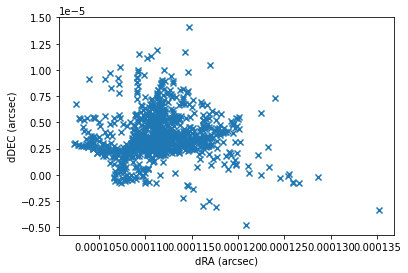

In [33]:
# use effective RA
dra = radec_objs['ra_est']*np.cos(radec_objs['dec_est'].data*u.deg) \
        -observed_xy_overlap['ra']*np.cos(observed_xy_overlap['dec'].data*u.deg)
ddec = ((radec_objs['dec_est']-observed_xy_overlap['dec']))
# print(' cos test=', np.cos(radec_objs['dec_est'].data*u.deg)-np.cos((radec_objs['dec_est'].data*u.deg).to_value(u.radian)))
dra_arcsec = (dra.data*u.deg).to_value(u.arcsec)
ddec_arcsec = (ddec.data*u.deg).to_value(u.arcsec)
plt.scatter(dra_arcsec, ddec_arcsec, marker='x')
plt.xlabel('dRA (arcsec)')
plt.ylabel('dDEC (arcsec)')
#plt.xlim([-0,8, 0.0])
#plt.ylim([-0.8, 0.0])

## Not fixing pointing RA, DEC, but use the reference stars. 

First, we define the model function to evaluate the difference in the sky coordinate of i-th stars, (ra, dec)i, from the individual plate, j-th plate, coordinates, (x, y)ij and the residual between (ra, dec)i and (ra, dec)k, for k-th reference stars whose (ra, dec)k is known from the other observation, e.g. Gaia. We use effecitve RA $\alpha_* = \alpha \cos(\delta)$.

In [34]:
def model_wrefs_func(params, n_fields, dim_sip, observed_xy, radec_refstars):
    # params = (ra_ptgs, dec_ptgs, pa_ptg..., scale, a..., b...)
    ra_ptgs, dec_ptgs, pa_ptgs, scale, a, b =\
        np.split(params, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
                          3*n_fields+1+(dim_sip+1)**2])

    field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
#                         names=['ra', 'dec', 'pa', 'field'],\
#                         units=[u.deg, u.deg, u.deg, None],\
#                         dtype=['float64', 'float64', 'float64', 'int64'])
    field_params['ra'].unit = u.deg
    field_params['dec'].unit = u.deg
    field_params['pa'].unit = u.deg
    field_params['field'] = np.arange(0, np.size(field_params))
    
    # use copy of observed_xy
    observed_xy_cp = observed_xy.copy()
    
    a_matrix = np.reshape(a, (dim_sip+1, dim_sip+1))
    b_matrix = np.reshape(b, (dim_sip+1, dim_sip+1))
    
    # mns = np.concatenate(((0, 1), np.arange(dim_sip+1, 2*(dim_sip)+1))) 
    # for mn in mns:
    #    for m in range(np.max([0, mn-dim_sip]), np.min([mn+1, dim_sip+1])):
    #        n = mn - m
    #        ap_matrix[m, n] = 0
    #        bp_matrix[m, n] = 0
    # a_matrix[0, 0] = 0.0
    # a_matrix[0, 1] = 0.0
    # a_matrix[1, 0] = 0.0
    # b_matrix[0, 0] = 0.0
    # b_matrix[0, 1] = 0.0
    # b_matrix[1, 0] = 0.0

    # normalisation. 
    m, n = np.indices((dim_sip+1, dim_sip+1))
    mn = m + n
    a_matrix = a_matrix * (1.e-3**mn)
    b_matrix = b_matrix * (1.e-3**mn)
    
    # compute ra/dec from x/y with the parameters.
    ret = radec_calculator_ab(observed_xy_cp, field_params, scale[0], \
                                                              a_matrix, b_matrix)
    
    observed_xy_cp['ra_est'] = ret['ra_est']
    observed_xy_cp['dec_est'] = ret['dec_est']
    
    # compute the mean ra/dec for unique stars
    cat_ids = unique(observed_xy_cp, 'catalog_id')['catalog_id']
    
    ra_mean = np.zeros(len(observed_xy['ra_est']))
    dec_mean = np.zeros(len(observed_xy['dec_est']))

    # effective RA
    observed_xy_cp['ra_est'] = observed_xy_cp['ra_est']*np.cos(observed_xy_cp['dec_est'].data*u.deg)

    for i in cat_ids:
        pos = np.where(observed_xy_cp['catalog_id'] == i)
        ra_mean[pos] = np.mean(observed_xy_cp[pos]['ra_est'])*u.deg
        dec_mean[pos] = np.mean(observed_xy_cp[pos]['dec_est'])*u.deg

    # effective RA for reference stars
    radec_refstars_cp = radec_refstars.copy()
    radec_refstars_cp.rename_column('ra', 'ra*')
    radec_refstars_cp['ra*'] = radec_refstars_cp['ra*']*np.cos(radec_refstars_cp['dec'].data*u.deg)
    # print(radec_refstars['ra'], radec_refstars_cp['ra*'])
        
    # reference stars' measured mean ra, dec to be compared 
    # with the ra, dec of reference stars. 
    radec_est_refstars = radec_refstars.copy()
    radec_est_refstars.rename_column('ra', 'ra_est')
    radec_est_refstars.rename_column('dec', 'dec_est')
    
    for i,id in enumerate(radec_refstars['catalog_id']):
      # print('i, id=', i, id)
      # print(ra_mean[observed_xy_cp['catalog_id'] == id][0])
      radec_est_refstars[i]['ra_est'] = ra_mean[observed_xy_cp['catalog_id'] == id][0]
      radec_est_refstars[i]['dec_est'] = dec_mean[observed_xy_cp['catalog_id'] == id][0]

    
    radec_est = np.concatenate((observed_xy_cp['ra_est'], observed_xy_cp['dec_est'], \
                              radec_refstars_cp['ra*'], radec_refstars_cp['dec']))
    radec_est_mean = np.concatenate((ra_mean, dec_mean, radec_est_refstars['ra_est'], \
                                    radec_est_refstars['dec_est']))
    
    # print(' ref stars al diff=', np.sum(radec_refstars_cp['ra*']-radec_est_refstars['ra_est']))
    
    residuals = radec_est - radec_est_mean

    return residuals

Pick the reference stars from true_radec_overlap of overlap stars. 

In [35]:
# print(' true_radec_overlap =', true_radec_overlap)
print(' len =', len(true_radec_overlap))

# number of reference stars
n_refstars = 10
pos = np.random.choice(len(true_radec_overlap), size=n_refstars, replace=False)
radec_refstars = true_radec_overlap[pos]
print(radec_refstars)

 len = 225
        ra                 dec         catalog_id
       deg                 deg                   
------------------ ------------------- ----------
 265.6186272627395 -28.671240903166122        200
 265.6392887852138 -28.802036147953846         41
 265.6061033890775  -28.67001512878799        209
 265.6513909005931 -28.741262397108585        161
265.57447434125095 -28.732351803934062        177
265.56955280295125 -28.684546430193095        189
 265.6200996364198 -28.701269477558576        193
 265.5636782256844 -28.675846350680942        190
 265.5830408536188 -28.801910778061764         96
 265.6990746644552 -28.724869548127785         71


Now, let's run least_squares and get the distortion parameters with the reference stars' constraints.

In [36]:
from scipy.optimize import least_squares
import time

dim_sip = 4
a = np.zeros(shape=(dim_sip+1, dim_sip+1))
b = np.zeros(shape=(dim_sip+1, dim_sip+1))

# constructing a_init (initial parameter set).
a_init = np.array(np.concatenate((field_params['ra'], field_params['dec'], \
                                  field_params['pa'], \
                                 [plate_scale.value], a.flatten(), b.flatten()))) # This must be an ndarray.
# a_init = np.array(np.concatenate((field_params['pa'], \
#                                  [plate_scale.value], a.flatten(), b.flatten()))) # This must be an ndarray.
print(' # of fitting parameters =', len(a_init))

print(' size of reference stars =', np.size(radec_refstars['catalog_id']))

start = time.time()
result = least_squares(model_wrefs_func, a_init, loss='linear', args= \
                       (np.size(field_params), dim_sip, observed_xy_overlap, \
                        radec_refstars), verbose=2)
print(' time=',time.time()-start)



 # of fitting parameters = 63
 size of reference stars = 10
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.1035e-03                                    6.75e+04    
       1              2         1.7407e-10      5.10e-03       8.07e+02       4.65e-03    
       2              3         1.8006e-16      1.74e-10       1.61e+03       2.49e-04    
       3              4         2.9652e-17      1.50e-16       3.23e+03       1.81e-04    
       4              6         1.3805e-17      1.58e-17       1.61e+03       3.93e-04    
       5              7         7.8543e-19      1.30e-17       4.03e+02       3.35e-05    
       6              8         1.1927e-19      6.66e-19       8.07e+02       2.49e-05    
       7              9         2.9532e-20      8.97e-20       1.61e+03       1.59e-05    
       8             10         3.0909e-21      2.64e-20       4.03e+02       3.79e-06    
       9             11       

## Checking restuls
#### Preparation

In [37]:
n_fields = np.size(field_params)
n_objects = np.size(radec_est)
true_ra_ptgs = true_field_params['ra'].data
true_dec_ptgs = true_field_params['dec'].data
true_pa_ptgs = true_field_params['pa'].data

ra_ptgs, dec_ptgs, pa_ptgs, scale, a, b =\
       np.split(result.x, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
                           3*n_fields+1+(dim_sip+1)**2])
# pa_ptgs, scale, a, b =\
#       np.split(result.x, [n_fields, n_fields+1,\
#                           n_fields+1+(dim_sip+1)**2])
#ra_ptgs = field_params['ra'].data
# dec_ptgs = field_params['dec'].data

a_matrix = np.reshape(a, (dim_sip+1, dim_sip+1))
b_matrix = np.reshape(b, (dim_sip+1, dim_sip+1))
# A/B scaling
m, n = np.indices((dim_sip+1, dim_sip+1))
mn = m + n
a_matrix = a_matrix * (1.e-3**mn)
b_matrix = b_matrix * (1.e-3**mn)

fit_field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
fit_field_params['ra'].unit = u.deg
fit_field_params['dec'].unit = u.deg
fit_field_params['pa'].unit = u.deg
fit_field_params['field'] = np.arange(0, np.size(field_params))

#### Pointings RA, DEC, position angle and scale

In [38]:
print(' pointing centre (fit) ra, dec (deg) =', ra_ptgs, dec_ptgs)
print(' pointing centre (true) ra, dec (deg) =', true_ra_ptgs, true_dec_ptgs)
print(' difference ra, dec (deg) =', ra_ptgs-true_ra_ptgs, dec_ptgs-true_dec_ptgs)
print(' position angle (fit) (deg) =', pa_ptgs)
print(' position angle (true) (deg) =', true_pa_ptgs)
print(' difference =', pa_ptgs-true_pa_ptgs)
print(' scale (fit, true) =', scale, (1e-6/7.3/np.pi*180.0)*u.deg/u.um)
print(' difference =', scale-(1e-6/7.3/np.pi*180.0))

 pointing centre (fit) ra, dec (deg) = [265.62153145 265.69963457 265.48921724 265.57142094] [-28.85151127 -28.74179839 -28.78387164 -28.67029473]
 pointing centre (true) ra, dec (deg) = [265.62153148 265.6996346  265.48921727 265.57142097] [-28.85151127 -28.74179839 -28.78387164 -28.67029473]
 difference ra, dec (deg) = [-3.11239887e-08 -3.10909627e-08 -3.11219992e-08 -3.09556754e-08] [2.48641285e-09 2.48918752e-09 2.19504770e-09 3.34204842e-09]
 position angle (fit) (deg) = [301.84893191 301.85328549 301.24458783 303.6562051 ]
 position angle (true) (deg) = [301.8490035  301.85335708 301.24465943 303.65627669]
 difference = [-7.15872694e-05 -7.15829369e-05 -7.15912893e-05 -7.15874466e-05]
 scale (fit, true) = [7.84875049e-06] 7.848736919600318e-06 deg / um
 difference = [1.35745028e-11]


with A00=A01=A10=0.

In [39]:
print(' pointing centre (fit) ra, dec (deg) =', ra_ptgs, dec_ptgs)
print(' pointing centre (true) ra, dec (deg) =', true_ra_ptgs, true_dec_ptgs)
print(' difference ra, dec (deg) =', ra_ptgs-true_ra_ptgs, dec_ptgs-true_dec_ptgs)
print(' position angle (fit) (deg) =', pa_ptgs)
print(' position angle (true) (deg) =', true_pa_ptgs)
print(' difference =', pa_ptgs-true_pa_ptgs)
print(' scale (fit, true) =', scale, (1e-6/7.3/np.pi*180.0)*u.deg/u.um)
print(' difference =', scale-(1e-6/7.3/np.pi*180.0))

 pointing centre (fit) ra, dec (deg) = [265.62153145 265.69963457 265.48921724 265.57142094] [-28.85151127 -28.74179839 -28.78387164 -28.67029473]
 pointing centre (true) ra, dec (deg) = [265.62153148 265.6996346  265.48921727 265.57142097] [-28.85151127 -28.74179839 -28.78387164 -28.67029473]
 difference ra, dec (deg) = [-3.11239887e-08 -3.10909627e-08 -3.11219992e-08 -3.09556754e-08] [2.48641285e-09 2.48918752e-09 2.19504770e-09 3.34204842e-09]
 position angle (fit) (deg) = [301.84893191 301.85328549 301.24458783 303.6562051 ]
 position angle (true) (deg) = [301.8490035  301.85335708 301.24465943 303.65627669]
 difference = [-7.15872694e-05 -7.15829369e-05 -7.15912893e-05 -7.15874466e-05]
 scale (fit, true) = [7.84875049e-06] 7.848736919600318e-06 deg / um
 difference = [1.35745028e-11]


Object positions

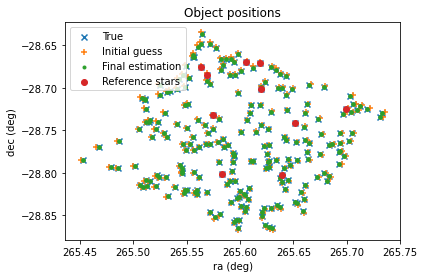

In [40]:
radec_objs = radec_calculator_ab(observed_xy_overlap, fit_field_params, scale[0], a_matrix, b_matrix)

plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(radec_est['ra_est'], radec_est['dec_est'], marker='+', label='Initial guess')
plt.scatter(radec_objs['ra_est'], radec_objs['dec_est'], marker='.', label='Final estimation')
plt.scatter(radec_refstars['ra'], radec_refstars['dec'], marker='o', \
            label='Reference stars')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Object positions')
plt.legend()

Position differences

(900,)


Text(0, 0.5, 'Number')

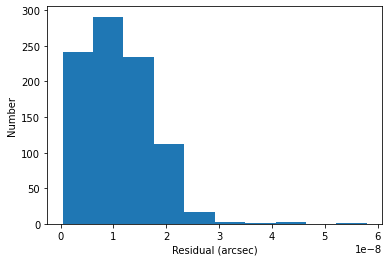

In [41]:
from astropy.coordinates import SkyCoord

distlist = []
print(np.shape(radec_objs))
for i in range(0, np.size(radec_objs)):
    c1 = SkyCoord(radec_objs['ra_est'][i]*u.deg, radec_objs['dec_est'][i]*u.deg)
    c2 = SkyCoord(observed_xy_overlap['ra'][i]*u.deg, observed_xy_overlap['dec'][i]*u.deg)
    distlist.append(c1.separation(c2).arcsec)
distlist = np.array(distlist)

#plt.hist(np.log10(distlist))
plt.hist(distlist)
plt.xlabel("Residual (arcsec)")
plt.ylabel("Number")

Text(0, 0.5, 'dDEC (arcsec)')

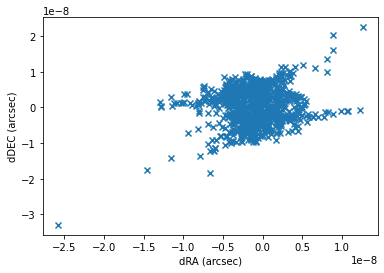

In [42]:
# dra = ((radec_objs['ra_est']-observed_xy_overlap['ra']).data)*u.deg
# effective RA
dra = radec_objs['ra_est']*np.cos(radec_objs['dec_est'].data*u.deg) \
        -observed_xy_overlap['ra']*np.cos(observed_xy_overlap['dec'].data*u.deg)
ddec = ((radec_objs['dec_est']-observed_xy_overlap['dec']).data)*u.deg
dra_arcsec = dra.to_value(u.arcsec)
ddec_arcsec = ddec.to_value(u.arcsec)
plt.scatter(dra_arcsec, ddec_arcsec, marker='x')
plt.xlabel('dRA (arcsec)')
plt.ylabel('dDEC (arcsec)')
#plt.xlim([-0,8, 0.0])
#plt.ylim([-0.8, 0.0])

#### Apply the field parameters to all the objects.

 total # of stars = 2574


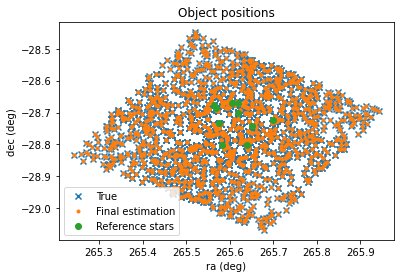

In [43]:
print(' total # of stars =', len(observed_xy))
radec_allobjs = radec_calculator_ab(observed_xy, fit_field_params, \
                                    scale[0], a_matrix, b_matrix)

plt.scatter(observed_xy['ra'], observed_xy['dec'], marker='x', label='True')
plt.scatter(radec_allobjs['ra_est'], radec_allobjs['dec_est'], marker='.', label='Final estimation')
plt.scatter(radec_refstars['ra'], radec_refstars['dec'], marker='o', \
            label='Reference stars')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Object positions')
plt.legend()

(2574,)


Text(0, 0.5, 'Number')

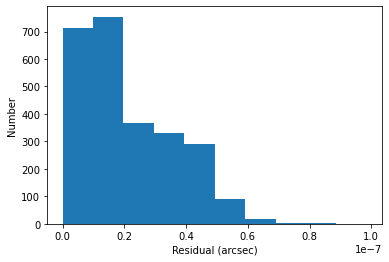

In [44]:
distlist = []
print(np.shape(radec_allobjs))
for i in range(0, np.size(radec_allobjs)):
    c1 = SkyCoord(radec_allobjs['ra_est'][i]*u.deg, radec_allobjs['dec_est'][i]*u.deg)
    c2 = SkyCoord(observed_xy['ra'][i]*u.deg, observed_xy['dec'][i]*u.deg)
    distlist.append(c1.separation(c2).arcsec)
distlist = np.array(distlist)

#plt.hist(np.log10(distlist))
plt.hist(distlist)
plt.xlabel("Residual (arcsec)")
plt.ylabel("Number")

Text(0, 0.5, 'dDEC (arcsec)')

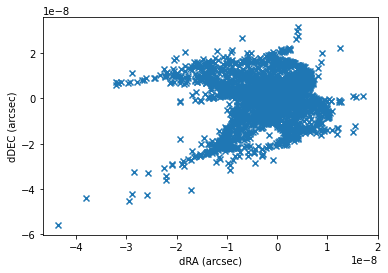

In [45]:
# dra = ((radec_allobjs['ra_est']-observed_xy['ra']).data)*u.deg
# effective RA
dra = radec_allobjs['ra_est']*np.cos(radec_allobjs['dec_est'].data*u.deg) \
        -observed_xy['ra']*np.cos(observed_xy['dec'].data*u.deg)
ddec = ((radec_allobjs['dec_est']-observed_xy['dec']).data)*u.deg
dra_arcsec = dra.to_value(u.arcsec)
ddec_arcsec = ddec.to_value(u.arcsec)
plt.scatter(dra_arcsec, ddec_arcsec, marker='x')
plt.xlabel('dRA (arcsec)')
plt.ylabel('dDEC (arcsec)')
#plt.xlim([-0,8, 0.0])
#plt.ylim([-0.8, 0.0])

## With observatioal errors.

We add the observational errors for both JASMINE observations and reference stars, Gaia stars. We first add the position error + displacement for observed_xy_overlap. Then, later we will add the noise to observed_xy (all observations). The displacement for the same observation of stars should be the same between observed_xy and observed_xy_overlap. However, for now for the simplification of set up, we use independent one.

In [46]:
# JASMINE pixel position uncertainty, let's set to 1/300 pix
pix_size = 15.*u.um
xy_error_jasmine = (1.0/300)*pix_size
print(' JASMINE pix error (um) =', xy_error_jasmine)
# Reference stars ra, dec error, let's set to 0.02 mas
radec_error_refstars = (0.1*u.mas).to(u.deg)
print(' Reference stars error (deg) =', radec_error_refstars)

 JASMINE pix error (um) = 0.05 um
 Reference stars error (deg) = 2.7777777777777784e-08 deg


In [47]:
# add errors to JASMINE pix position
# for overlap stars
observed_xy_overlap.rename_column('x', 'x0')
observed_xy_overlap.rename_column('y', 'y0')
observed_xy_overlap.add_column(observed_xy_overlap['x0'], name='x')
observed_xy_overlap.add_column(observed_xy_overlap['x0'], name='y')

observed_xy_overlap['x'] = np.random.normal(observed_xy_overlap['x0'], xy_error_jasmine)
observed_xy_overlap['y'] = np.random.normal(observed_xy_overlap['y0'], xy_error_jasmine)
# store the noise
observed_xy_overlap.add_column(observed_xy_overlap['x'], name='xy_err')

In [48]:
observed_xy_overlap['xy_err'] = xy_error_jasmine

In [49]:
# for all stars
observed_xy.rename_column('x', 'x0')
observed_xy.rename_column('y', 'y0')
observed_xy.add_column(observed_xy['x0'], name='x')
observed_xy.add_column(observed_xy['x0'], name='yt')

observed_xy['x'] = np.random.normal(observed_xy['x0'], xy_error_jasmine)
observed_xy['y'] = np.random.normal(observed_xy['y0'], xy_error_jasmine)
observed_xy.add_column(observed_xy['x'], name='xy_err')

In [50]:
observed_xy['xy_err'] = xy_error_jasmine

In [51]:
# add errors to reference stars
radec_refstars.rename_column('ra', 'ra0')
radec_refstars.rename_column('dec', 'dec0')
radec_refstars.add_column(radec_refstars['ra0'], name='ra')
radec_refstars.add_column(radec_refstars['dec0'], name='dec')


# print(' ra before noise =', radec_refstars['ra'])
radec_refstars['ra'] = np.random.normal(radec_refstars['ra0'], radec_error_refstars)
radec_refstars['dec'] = np.random.normal(radec_refstars['dec0'], radec_error_refstars)
# print(' ra w/added noise =', radec_refstars['ra'].to_value(u.mas))
# store the noise
radec_refstars.add_column(radec_refstars['ra'], name='radec_err')

In [52]:
radec_refstars['radec_err'] = radec_error_refstars

We define the model function. We use effecitve RA $\alpha_* = \alpha \cos(\delta)$, when we compute residuals. Note that the errors are not needed to be adjusted with effective RA. 

In [53]:
def model_wrefs_werr_func(params, n_fields, dim_sip, observed_xy, radec_refstars):
    # params = (ra_ptgs, dec_ptgs, pa_ptg..., scale, a..., b...)
    ra_ptgs, dec_ptgs, pa_ptgs, scale, a, b =\
        np.split(params, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
                          3*n_fields+1+(dim_sip+1)**2])

    field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
#                         names=['ra', 'dec', 'pa', 'field'],\
#                         units=[u.deg, u.deg, u.deg, None],\
#                         dtype=['float64', 'float64', 'float64', 'int64'])
    field_params['ra'].unit = u.deg
    field_params['dec'].unit = u.deg
    field_params['pa'].unit = u.deg
    field_params['field'] = np.arange(0, np.size(field_params))
    
    # use copy of observed_xy
    observed_xy_cp = observed_xy.copy()
    
    a_matrix = np.reshape(a, (dim_sip+1, dim_sip+1))
    b_matrix = np.reshape(b, (dim_sip+1, dim_sip+1))
    
    # mns = np.concatenate(((0, 1), np.arange(dim_sip+1, 2*(dim_sip)+1))) 
    # for mn in mns:
    #    for m in range(np.max([0, mn-dim_sip]), np.min([mn+1, dim_sip+1])):
    #        n = mn - m
    #        ap_matrix[m, n] = 0
    #        bp_matrix[m, n] = 0
    # a_matrix[0, 0] = 0.0
    # a_matrix[0, 1] = 0.0
    # a_matrix[1, 0] = 0.0
    # b_matrix[0, 0] = 0.0
    # b_matrix[0, 1] = 0.0
    # b_matrix[1, 0] = 0.0

    # normalisation. 
    m, n = np.indices((dim_sip+1, dim_sip+1))
    mn = m + n
    a_matrix = a_matrix * (1.e-3**mn)
    b_matrix = b_matrix * (1.e-3**mn)
    
    # compute ra/dec from x/y with the parameters.
    ret = radec_calculator_ab(observed_xy_cp, field_params, scale[0], \
                                                              a_matrix, b_matrix)
    
    observed_xy_cp['ra_est'] = ret['ra_est']
    observed_xy_cp['dec_est'] = ret['dec_est']
    
    # compute the mean ra/dec for unique stars
    cat_ids = unique(observed_xy_cp, 'catalog_id')['catalog_id']

    ra_mean = np.zeros(len(observed_xy['ra_est']))
    dec_mean = np.zeros(len(observed_xy['dec_est']))

    # compute weights from error in xy (um) -> radec (deg)
    # wra_observed_xy = 1.0/(observed_xy_cp['xy_err']*scale[0]*np.cos(observed_xy_cp['dec_est'].data*u.deg))
    wra_observed_xy = 1.0/(observed_xy_cp['xy_err']*scale[0])
    wdec_observed_xy = 1.0/(observed_xy_cp['xy_err']*scale[0])
    
    # effective RA: error does not need to adjusted.
    observed_xy_cp['ra_est'] = observed_xy_cp['ra_est']*np.cos(observed_xy_cp['dec_est'].data*u.deg)

    for i in cat_ids:
        pos = np.where(observed_xy_cp['catalog_id'] == i)
        ra_mean[pos] = np.average(observed_xy_cp[pos]['ra_est'], \
                                 weights=wra_observed_xy[pos])*u.deg
        dec_mean[pos] = np.average(observed_xy_cp[pos]['dec_est'], \
                                 weights=wdec_observed_xy[pos])*u.deg

    # effective RA for reference stars
    radec_refstars_cp = radec_refstars.copy()
    radec_refstars_cp.rename_column('ra', 'ra*')
    radec_refstars_cp['ra*'] = radec_refstars_cp['ra*']*np.cos(radec_refstars_cp['dec'].data*u.deg)
    # print(radec_refstars['ra'], radec_refstars_cp['ra*'])

    # reference stars' measured mean ra, dec to be compared 
    # with the ra, dec of reference stars. 
    radec_est_refstars = radec_refstars.copy()
    radec_est_refstars.rename_column('ra', 'ra*_est')
    radec_est_refstars.rename_column('dec', 'dec_est')
    # compute weights for reference stars
    # wra_refstars = 1.0/(radec_refstars_cp['radec_err']*np.cos(radec_refstars_cp['dec'].data*u.deg))
    wra_refstars = 1.0/(radec_refstars_cp['radec_err'])
    wdec_refstars = 1.0/(radec_refstars_cp['radec_err'])
    
    for i,id in enumerate(radec_refstars['catalog_id']):
      # print('i, id=', i, id)
      # print(ra_mean[observed_xy_cp['catalog_id'] == id][0])
      radec_est_refstars[i]['ra*_est'] = ra_mean[observed_xy_cp['catalog_id'] == id][0]
      radec_est_refstars[i]['dec_est'] = dec_mean[observed_xy_cp['catalog_id'] == id][0]

    radec_est = np.concatenate((observed_xy_cp['ra_est'], observed_xy_cp['dec_est'], \
                              radec_refstars_cp['ra*'], radec_refstars_cp['dec']))
    radec_est_mean = np.concatenate((ra_mean, dec_mean, radec_est_refstars['ra*_est'], \
                                    radec_est_refstars['dec_est']))
    w_all = np.concatenate((wra_observed_xy, wdec_observed_xy, wra_refstars, wdec_refstars))
    
    # print(w_all)
    
    residuals = w_all*(radec_est - radec_est_mean)

    return residuals

Let's run least squares. 

In [54]:
from scipy.optimize import least_squares
from scipy.optimize import leastsq
import time

dim_sip = 5
a = np.zeros(shape=(dim_sip+1, dim_sip+1))
b = np.zeros(shape=(dim_sip+1, dim_sip+1))

# constructing a_init (initial parameter set).
a_init = np.array(np.concatenate((field_params['ra'], field_params['dec'], \
                                  field_params['pa'], \
                                 [plate_scale.value], a.flatten(), b.flatten()))) # This must be an ndarray.
# a_init = np.array(np.concatenate((field_params['pa'], \
#                                  [plate_scale.value], a.flatten(), b.flatten()))) # This must be an ndarray.
print(' # of fitting parameters =', len(a_init))

print(' size of reference stars =', np.size(radec_refstars['catalog_id']))

start = time.time()
result = least_squares(model_wrefs_werr_func, a_init, loss='linear', args= \
                        (np.size(field_params), dim_sip, observed_xy_overlap, \
                        radec_refstars), verbose=2)
# result = least_squares(model_wrefs_werr_func, a_init, args= \
#                       (np.size(field_params), dim_sip, observed_xy_overlap, \
#                        radec_refstars))
print(' time=',time.time()-start)




 # of fitting parameters = 85
 size of reference stars = 10
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.5330e+10                                    1.25e+18    
       1              2         1.4167e+07      9.53e+10       8.07e+02       8.96e+15    
       2              3         2.9988e+03      1.42e+07       1.61e+03       1.20e+13    
       3              4         2.9796e+03      1.92e+01       3.23e+03       1.32e+13    
       4              5         2.9698e+03      9.83e+00       8.07e+02       7.20e+12    
       5              6         2.9417e+03      2.81e+01       2.02e+02       4.03e+12    
       6             14         2.9322e+03      9.51e+00       1.23e-02       1.06e+12    
       7             16         2.9316e+03      6.26e-01       3.08e-03       6.86e+11    
       8             17         2.9315e+03      3.90e-02       7.69e-04       3.86e+10    
       9             20       

## Checking results

Extract the results.

In [55]:
n_fields = np.size(field_params)
n_objects = np.size(radec_est)
true_ra_ptgs = true_field_params['ra'].data
true_dec_ptgs = true_field_params['dec'].data
true_pa_ptgs = true_field_params['pa'].data

ra_ptgs, dec_ptgs, pa_ptgs, scale, a, b =\
       np.split(result.x, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
                           3*n_fields+1+(dim_sip+1)**2])
# pa_ptgs, scale, a, b =\
#       np.split(result.x, [n_fields, n_fields+1,\
#                           n_fields+1+(dim_sip+1)**2])
#ra_ptgs = field_params['ra'].data
# dec_ptgs = field_params['dec'].data

print(' a and b matrices before scaling=', a, b)

a_matrix = np.reshape(a, (dim_sip+1, dim_sip+1))
b_matrix = np.reshape(b, (dim_sip+1, dim_sip+1))
# A/B scaling
m, n = np.indices((dim_sip+1, dim_sip+1))
mn = m + n
a_matrix = a_matrix * (1.e-3**mn)
b_matrix = b_matrix * (1.e-3**mn)

fit_field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
fit_field_params['ra'].unit = u.deg
fit_field_params['dec'].unit = u.deg
fit_field_params['pa'].unit = u.deg
fit_field_params['field'] = np.arange(0, np.size(field_params))

 a and b matrices before scaling= [-8.21460423e-02  3.57233480e-02  2.00179399e-03 -5.28296513e-05
 -1.17470968e-07  1.29295093e-07 -6.37251451e-04 -1.58695283e-02
 -1.50819445e-05 -1.29627697e-07  1.36988930e-08 -9.92433677e+02
  4.54015571e-03 -1.00992844e-05 -7.23272332e-08 -2.20198053e-09
  1.06245213e+03 -1.20951642e+03  3.99500136e-05  8.19066331e-08
 -8.97893345e-10 -3.80479664e+02 -1.33002366e+02 -4.35061759e+02
  4.92636950e-07  2.09944650e-08  6.55336742e+02  1.31735940e+01
 -5.90105362e+02  3.06574360e+02 -9.71902166e-08 -4.18363991e+02
  6.11151037e+02 -4.23729906e+02 -1.47472964e+02 -3.88041075e+02] [-8.13365800e-02  9.87448687e-03  1.88816296e-02 -6.07557522e-05
  7.91854848e-07  1.41128175e-07 -3.29575060e-02  6.03521503e-03
  1.13105480e-05 -9.19886286e-07 -1.11026959e-08 -3.78105948e+02
 -2.77610232e-03 -2.04226790e-06 -1.38406293e-07 -3.83296751e-09
  2.12503196e+02  6.22038776e+02  1.04371565e-05  6.00522716e-07
  1.20386344e-08 -1.37500715e+03  3.87341356e+02  2.106

Evaluate fitting. We follow https://www.fixes.pub/program/444521.html.

In [56]:
from scipy import linalg, optimize

chi2dof= np.sum(result.fun**2)/(result.fun.size -result.x.size)
print(' Xi^2/dof =', chi2dof)

J= result.jac
print(' shape of J =', np.shape(J))
# this does not work.
# cov= np.linalg.inv(J.T.dot(J))
# var= np.sqrt(np.diagonal(cov))
# print(' parameter variances =', var)

U, s, Vh= linalg.svd(result.jac, full_matrices=False)
tol= np.finfo(float).eps*s[0]*max(result.jac.shape)
w= s > tol
cov= (Vh[w].T/s[w]**2) @ Vh[w]  # robust covariance matrix
cov *= chi2dof
perr= np.sqrt(np.diag(cov))     # 1sigma uncertainty on fitted parameters

# extract errors

ra_ptgs_err, dec_ptgs_err, pa_ptgs_err, scale_err, a_err, b_err =\
       np.split(perr, [n_fields, 2*n_fields, 3*n_fields, 3*n_fields+1,\
                           3*n_fields+1+(dim_sip+1)**2])

# A/B scaling
a_err_matrix = np.reshape(a_err, (dim_sip+1, dim_sip+1))
b_err_matrix = np.reshape(b_err, (dim_sip+1, dim_sip+1))
# A/B scaling
m, n = np.indices((dim_sip+1, dim_sip+1))
mn = m + n
a_err_matrix = a_err_matrix * (1.e-3**mn)
b_err_matrix = b_err_matrix * (1.e-3**mn)

print(' parameter values =', ra_ptgs, dec_ptgs, pa_ptgs, scale, a_matrix, b_matrix)
print(' parameter variances =', ra_ptgs_err, dec_ptgs_err, pa_ptgs_err, scale_err, \
     a_err_matrix, b_err_matrix)

 Xi^2/dof = 3.379297624405136
 shape of J = (1820, 85)
 parameter values = [265.62153099 265.69963357 265.48921594 265.57141984] [-28.85151174 -28.7417985  -28.78387169 -28.67029486] [301.85053767 301.85471156 301.24689333 303.65836692] [7.84872462e-06] [[-8.21460423e-02  3.57233480e-05  2.00179399e-09 -5.28296513e-14
  -1.17470968e-19  1.29295093e-22]
 [-6.37251451e-07 -1.58695283e-08 -1.50819445e-14 -1.29627697e-19
   1.36988930e-23 -9.92433677e-16]
 [ 4.54015571e-09 -1.00992844e-14 -7.23272332e-20 -2.20198053e-24
   1.06245213e-15 -1.20951642e-18]
 [ 3.99500136e-14  8.19066331e-20 -8.97893345e-25 -3.80479664e-16
  -1.33002366e-19 -4.35061759e-22]
 [ 4.92636950e-19  2.09944650e-23  6.55336742e-16  1.31735940e-20
  -5.90105362e-22  3.06574360e-25]
 [-9.71902166e-23 -4.18363991e-16  6.11151037e-19 -4.23729906e-22
  -1.47472964e-25 -3.88041075e-28]] [[-8.13365800e-02  9.87448687e-06  1.88816296e-08 -6.07557522e-14
   7.91854848e-19  1.41128175e-22]
 [-3.29575060e-05  6.03521503e-09  1.1

#### Pointings RA, DEC, position angle and scale

In [57]:
print(' pointing centre (fit) ra, dec (deg) =', ra_ptgs, dec_ptgs)
print(' pointing centre (true) ra, dec (deg) =', true_ra_ptgs, true_dec_ptgs)
print(' difference ra, dec (deg) =', ra_ptgs-true_ra_ptgs, dec_ptgs-true_dec_ptgs)
print(' uncertainty ra, dec pointings =', ra_ptgs_err, dec_ptgs_err)

 pointing centre (fit) ra, dec (deg) = [265.62153099 265.69963357 265.48921594 265.57141984] [-28.85151174 -28.7417985  -28.78387169 -28.67029486]
 pointing centre (true) ra, dec (deg) = [265.62153148 265.6996346  265.48921727 265.57142097] [-28.85151127 -28.74179839 -28.78387164 -28.67029473]
 difference ra, dec (deg) = [-4.90150740e-07 -1.03085790e-06 -1.32636018e-06 -1.13180965e-06] [-4.67642337e-07 -1.04528141e-07 -4.59036684e-08 -1.20876187e-07]
 uncertainty ra, dec pointings = [3.82728032e-07 3.01425891e-07 3.55587451e-07 2.68414831e-07] [1.42821420e-07 1.23874802e-07 1.51347249e-07 1.18461552e-07]


with A00=A01=A10=0.

In [58]:
print(' pointing centre (fit) ra, dec (deg) =', ra_ptgs, dec_ptgs)
print(' pointing centre (true) ra, dec (deg) =', true_ra_ptgs, true_dec_ptgs)
print(' difference ra, dec (deg) =', ra_ptgs-true_ra_ptgs, dec_ptgs-true_dec_ptgs)
print(' uncertainty ra, dec pointings =', ra_ptgs_err, dec_ptgs_err)

 pointing centre (fit) ra, dec (deg) = [265.62153099 265.69963357 265.48921594 265.57141984] [-28.85151174 -28.7417985  -28.78387169 -28.67029486]
 pointing centre (true) ra, dec (deg) = [265.62153148 265.6996346  265.48921727 265.57142097] [-28.85151127 -28.74179839 -28.78387164 -28.67029473]
 difference ra, dec (deg) = [-4.90150740e-07 -1.03085790e-06 -1.32636018e-06 -1.13180965e-06] [-4.67642337e-07 -1.04528141e-07 -4.59036684e-08 -1.20876187e-07]
 uncertainty ra, dec pointings = [3.82728032e-07 3.01425891e-07 3.55587451e-07 2.68414831e-07] [1.42821420e-07 1.23874802e-07 1.51347249e-07 1.18461552e-07]


In [59]:
print(' position angle (fit) (deg) =', pa_ptgs)
print(' position angle (true) (deg) =', true_pa_ptgs)
print(' difference =', pa_ptgs-true_pa_ptgs)
print(' uncertainty =', pa_ptgs_err)

 position angle (fit) (deg) = [301.85053767 301.85471156 301.24689333 303.65836692]
 position angle (true) (deg) = [301.8490035  301.85335708 301.24465943 303.65627669]
 difference = [0.00153417 0.00135449 0.0022339  0.00209023]
 uncertainty = [0.00035704 0.00035617 0.00036402 0.00035833]


with A00=A01=A10=0.

In [60]:
print(' position angle (fit) (deg) =', pa_ptgs)
print(' position angle (true) (deg) =', true_pa_ptgs)
print(' difference =', pa_ptgs-true_pa_ptgs)
print(' uncertainty =', pa_ptgs_err)

 position angle (fit) (deg) = [301.85053767 301.85471156 301.24689333 303.65836692]
 position angle (true) (deg) = [301.8490035  301.85335708 301.24465943 303.65627669]
 difference = [0.00153417 0.00135449 0.0022339  0.00209023]
 uncertainty = [0.00035704 0.00035617 0.00036402 0.00035833]


In [61]:
print(' scale (fit, true) =', scale, (1e-6/7.3/np.pi*180.0)*u.deg/u.um)
print(' difference =', scale-(1e-6/7.3/np.pi*180.0))
print(' uncertainty =', scale_err)

 scale (fit, true) = [7.84872462e-06] 7.848736919600318e-06 deg / um
 difference = [-1.23004789e-11]
 uncertainty = [5.74806634e-11]


with A00=A01=A10=0.

In [62]:
print(' scale (fit, true) =', scale, (1e-6/7.3/np.pi*180.0)*u.deg/u.um)
print(' difference =', scale-(1e-6/7.3/np.pi*180.0))
print(' uncertainty =', scale_err)

 scale (fit, true) = [7.84872462e-06] 7.848736919600318e-06 deg / um
 difference = [-1.23004789e-11]
 uncertainty = [5.74806634e-11]


#### Objects positions

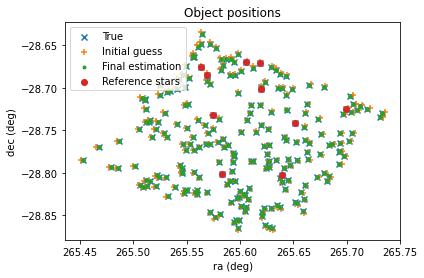

In [63]:
radec_objs = radec_calculator_ab(observed_xy_overlap, fit_field_params, scale[0], a_matrix, b_matrix)

plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(radec_est['ra_est'], radec_est['dec_est'], marker='+', label='Initial guess')
plt.scatter(radec_objs['ra_est'], radec_objs['dec_est'], marker='.', label='Final estimation')
plt.scatter(radec_refstars['ra0'], radec_refstars['dec0'], marker='o', \
            label='Reference stars')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Object positions')
plt.legend()

(900,)


Text(0, 0.5, 'Number')

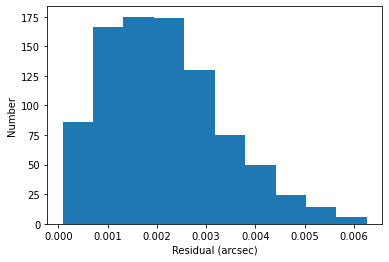

In [64]:
distlist = []
print(np.shape(radec_objs))
for i in range(0, np.size(radec_objs)):
    c1 = SkyCoord(radec_objs['ra_est'][i]*u.deg, radec_objs['dec_est'][i]*u.deg)
    c2 = SkyCoord(observed_xy_overlap['ra'][i]*u.deg, observed_xy_overlap['dec'][i]*u.deg)
    distlist.append(c1.separation(c2).arcsec)
distlist = np.array(distlist)

#plt.hist(np.log10(distlist))
plt.hist(distlist)
plt.xlabel("Residual (arcsec)")
plt.ylabel("Number")

Text(0, 0.5, 'dDEC (arcsec)')

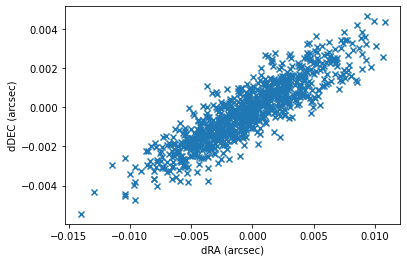

In [65]:
# dra = ((radec_objs['ra_est']-observed_xy_overlap['ra']).data)*u.deg
# effective RA
dra = radec_objs['ra_est']*np.cos(radec_objs['dec_est'].data*u.deg) \
        -observed_xy_overlap['ra']*np.cos(observed_xy_overlap['dec'].data*u.deg)
ddec = ((radec_objs['dec_est']-observed_xy_overlap['dec']).data)*u.deg
dra_arcsec = dra.to_value(u.arcsec)
ddec_arcsec = ddec.to_value(u.arcsec)
plt.scatter(dra_arcsec, ddec_arcsec, marker='x')
plt.xlabel('dRA (arcsec)')
plt.ylabel('dDEC (arcsec)')

#### Apply to all the data, taking into account uncertainties of their position and parameter uncertainties.

We shall run Monte Carlo by randomly displacing the position of stars and distortion parameters.

 total # of stars = 2574
 mean dec correction for effective RA = 0.876666331377697
 RA mean standard deviation of measurements (arcsec) = 0.012150612267002803
 RA standard deviation from the true values (arcsec) = 0.007578648586443364
 DEC mean standard deviation of measurements (arcsec) = 0.005951970506983575
 DEC standard deviation from the true values (arcsec)= 0.0032455863788301282


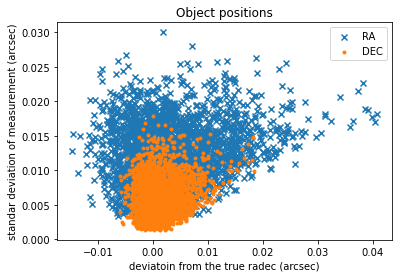

In [66]:
n_mc = 100

n_stars = len(observed_xy)
print(' total # of stars =', n_stars)
ra_allobjs_samp = np.empty((n_stars, n_mc))
dec_allobjs_samp = np.empty((n_stars, n_mc))

observed_xy_try = observed_xy.copy()
# flattened uncertainties of a, b matrix
a_flat = a_matrix.flatten()
b_flat = b_matrix.flatten()
a_err = a_err_matrix.flatten()
b_err = b_err_matrix.flatten()

for i in range(n_mc):
    # displace observed_xy positions
    observed_xy_try['x'] = np.random.normal(observed_xy['x'], observed_xy['xy_err'])
    observed_xy_try['y'] = np.random.normal(observed_xy['y'], observed_xy['xy_err'])

    # displace the parameters
    ra_ptgs_try = np.random.normal(ra_ptgs, ra_ptgs_err)
    dec_ptgs_try = np.random.normal(dec_ptgs, dec_ptgs_err)
    pa_ptgs_try = np.random.normal(pa_ptgs, pa_ptgs_err)
    scale_try = np.random.normal(scale, scale_err) 
    a_try = np.random.normal(a_flat, a_err)
    b_try = np.random.normal(b_flat, b_err)
    a_matrix_try = np.reshape(a_try, (dim_sip+1, dim_sip+1))
    b_matrix_try = np.reshape(b_try, (dim_sip+1, dim_sip+1))
    
    fit_field_params_try = Table(data=[ra_ptgs_try, dec_ptgs_try, pa_ptgs_try, \
                                   -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
    fit_field_params_try['ra'].unit = u.deg
    fit_field_params_try['dec'].unit = u.deg
    fit_field_params_try['pa'].unit = u.deg
    fit_field_params_try['field'] = np.arange(0, np.size(field_params))
    
    radec_allobjs_try = radec_calculator_ab(observed_xy_try, fit_field_params_try, \
                                    scale_try[0], a_matrix_try, b_matrix_try)
    # use effective RA
    ra_allobjs_samp[:, i] = radec_allobjs_try['ra_est']*np.cos(radec_allobjs_try['dec_est'].data*u.deg)
    # ra_allobjs_samp[:, i] = radec_allobjs_try['ra_est']
    dec_allobjs_samp[:, i] = radec_allobjs_try['dec_est']
    

ra_allobjs_mean = np.mean(ra_allobjs_samp, axis=1)*u.deg
ra_allobjs_std = np.std(ra_allobjs_samp, axis=1)
dec_allobjs_mean = np.mean(dec_allobjs_samp, axis=1)*u.deg
dec_allobjs_std = np.std(dec_allobjs_samp, axis=1)

# we convert true obserfved ra to effective ra
raeff_observed_xy = observed_xy['ra']*np.cos(observed_xy['dec'].data*u.deg)
# raeff_observed_xy = observed_xy['ra']
dec_observed_xy = observed_xy['dec']

print(' mean dec correction for effective RA =', np.mean(np.cos(observed_xy['dec'].data*u.deg)))

# print(raeff_observed_xy, ra_allobjs_mean)

# error from the true value
ra_allobjs_err = ra_allobjs_mean-raeff_observed_xy
dec_allobjs_err = dec_allobjs_mean-dec_observed_xy

plt.scatter(ra_allobjs_err.to_value(u.arcsec), (ra_allobjs_std*u.deg).to_value(u.arcsec), marker='x', label='RA')
plt.scatter(dec_allobjs_err.to_value(u.arcsec), (dec_allobjs_std*u.deg).to_value(u.arcsec), marker='.', label='DEC')

print(' RA mean standard deviation of measurements (arcsec) =', \
      (np.mean(ra_allobjs_std)*u.deg).to_value(u.arcsec))
print(' RA standard deviation from the true values (arcsec) =', 
      (np.std(ra_allobjs_err)).to_value(u.arcsec))
print(' DEC mean standard deviation of measurements (arcsec) =', 
      (np.mean(dec_allobjs_std)*u.deg).to_value(u.arcsec))
print(' DEC standard deviation from the true values (arcsec)=', 
      (np.std(dec_allobjs_err)).to_value(u.arcsec))

plt.xlabel('deviatoin from the true radec (arcsec)')
plt.ylabel('standar deviation of measurement (arcsec)')
plt.title('Object positions')
plt.legend()